In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import pennylane as qml
import numpy as np
import tensorflow as tf

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

In [4]:
seed = 4321
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float64')

In [69]:
x,y = load_breast_cancer(return_X_y = True)
x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.4)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [70]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

In [71]:
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

# Restrict all the values to be between 0 and 1.
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [72]:
pca = PCA(n_components = 20)

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

In [91]:
def TwoLocal(nqubits, theta, reps = 1):
    
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires = i)
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires = i)

In [75]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [92]:
nqubits = 5
dev = qml.device("lightning.qubit", wires=nqubits)

@qml.qnode(dev, interface="tf")
def qnn(inputs, weights):
    qml.AngleEmbedding(inputs, range(nqubits), rotation="Y")
    #qml.StronglyEntanglingLayers(weights, range(nqubits))
    TwoLocal(nqubits, weights, reps=4)
    return [qml.expval(qml.Hermitian(M, wires=[q])) for q in range(nqubits)]

In [93]:
@qml.qnode(dev, interface="tf")
def qnn_final(inputs, weights):
    qml.AngleEmbedding(inputs, range(nqubits), rotation="Y")
    #qml.StronglyEntanglingLayers(weights, range(nqubits))
    TwoLocal(nqubits, weights, reps=4)
    return qml.expval(qml.Hermitian(M, wires=[0]))

C:\Users\mathe\AppData\Local\Temp\ipykernel_7448\2800505709.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


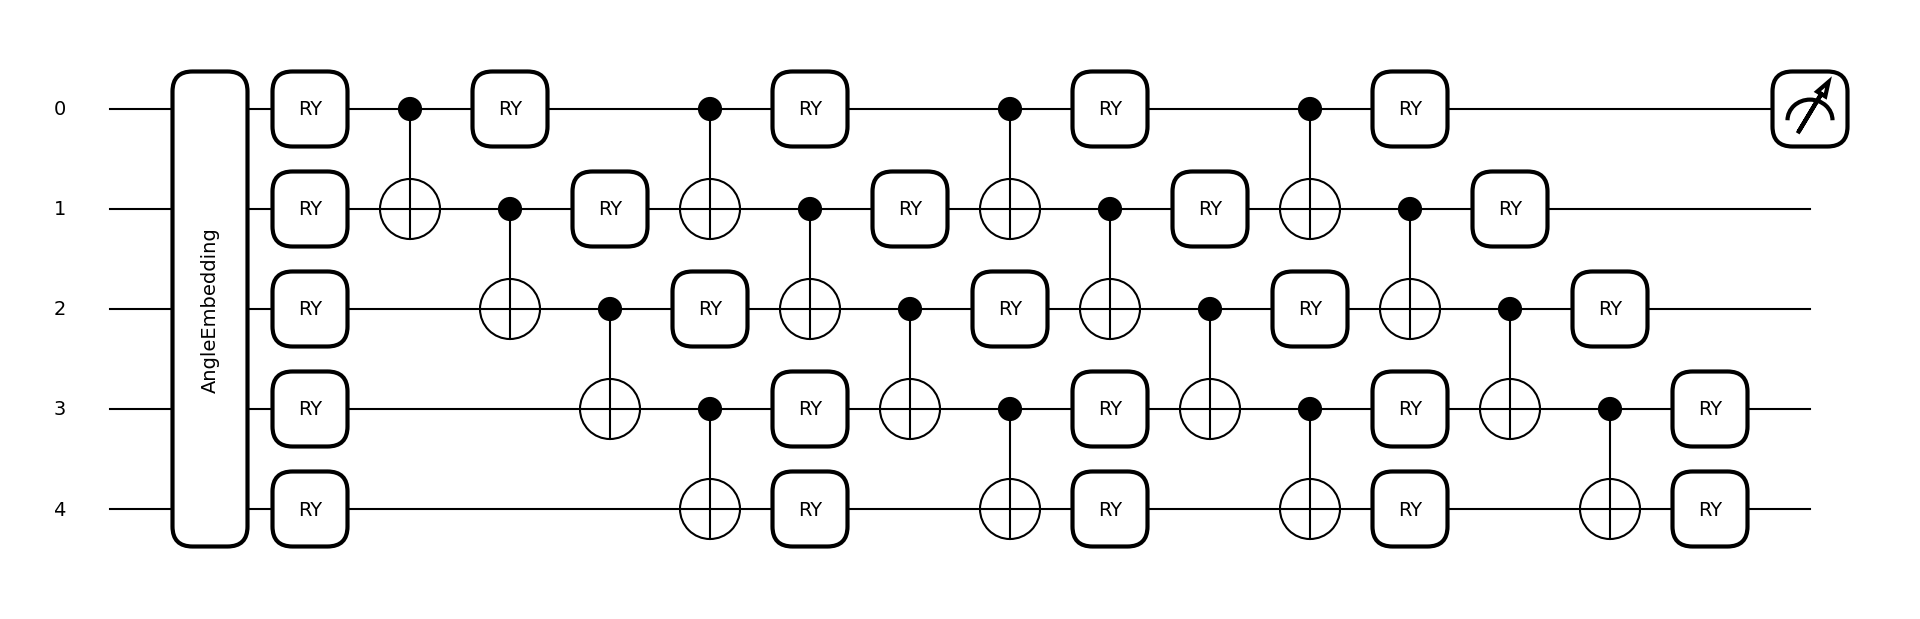

In [172]:
fig, ax = qml.draw_mpl(qnn_final)(range(5), range(25))
fig.show()

In [94]:
weights = {"weights": 25}
qlayer1 = qml.qnn.KerasLayer(qnn, weight_shapes=weights, output_dim=5)

In [95]:
weightsf = {"weights": 25}
qlayer2 = qml.qnn.KerasLayer(qnn_final, weight_shapes=weightsf, output_dim=1)

In [179]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(20),
    tf.keras.layers.Dense(10, activation = "relu"), 
    tf.keras.layers.Dense(5, activation = "softmax"),
    #qlayer1,
    qlayer2
    #tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

In [180]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
model.compile(opt, loss=tf.keras.losses.BinaryCrossentropy())

In [181]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 2, verbose = 1,
    restore_best_weights = True)

In [182]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 10)                210       
                                                                 
 dense_41 (Dense)            (None, 5)                 55        
                                                                 
 keras_layer_8 (KerasLayer)  (None, 1)                 25        
                                                                 
Total params: 290 (2.27 KB)
Trainable params: 290 (2.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [183]:
history = model.fit(xs_tr, y_tr, epochs = 100, shuffle = True,
    validation_data = (xs_val, y_val),
    batch_size = 20, 
    callbacks = [earlystop])

Epoch 1/100
12/12 [==============================] - 6s 480ms/step - loss: 0.6525 - val_loss: 0.6404
Epoch 2/100
12/12 [==============================] - 6s 503ms/step - loss: 0.6270 - val_loss: 0.6136
Epoch 3/100
12/12 [==============================] - 5s 457ms/step - loss: 0.5899 - val_loss: 0.5724
Epoch 4/100
12/12 [==============================] - 6s 478ms/step - loss: 0.5336 - val_loss: 0.5106
Epoch 5/100
12/12 [==============================] - 6s 500ms/step - loss: 0.4651 - val_loss: 0.4452
Epoch 6/100
12/12 [==============================] - 6s 471ms/step - loss: 0.4006 - val_loss: 0.3872
Epoch 7/100
12/12 [==============================] - 6s 471ms/step - loss: 0.3489 - val_loss: 0.3432
Epoch 8/100
12/12 [==============================] - 6s 461ms/step - loss: 0.3114 - val_loss: 0.3104
Epoch 9/100
12/12 [==============================] - 6s 473ms/step - loss: 0.2854 - val_loss: 0.2904
Epoch 10/100
12/12 [==============================] - 6s 497ms/step - loss: 0.2694 - val_lo

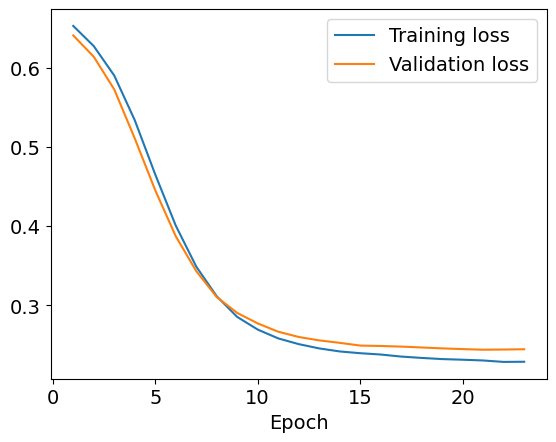

In [184]:
import matplotlib.pyplot as plt

def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_losses(history)

In [159]:
from sklearn.metrics import accuracy_score

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

6/6 [==============================] - 1s 175ms/step
Train accuracy: 0.9823788546255506
Validation accuracy: 0.9649122807017544
Test accuracy: 0.9532163742690059


In [143]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set
y_pred = (model.predict(xs_test) > 0.5).astype(int)
y_true = y_test

6/6 [==============================] - 0s 2ms/step


In [160]:
def plot_confusion_matrix(cm, class_names=None):
    figure = plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(cm.shape[0])]
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    cm_display.plot(values_format='d', cmap='Blues', ax=plt.gca())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    return figure

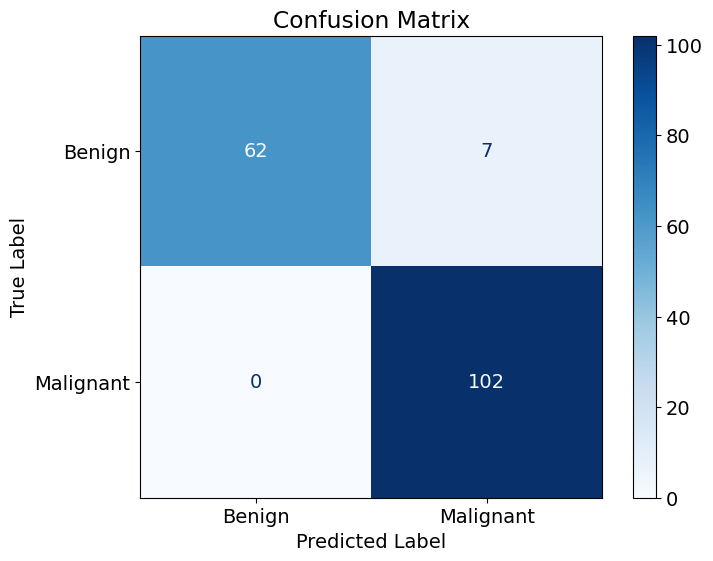

In [161]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix


# Plot the confusion matrix
class_names = ['Benign', 'Malignant']
plot_confusion_matrix(cm, class_names)
plt.show()